# Predict topics of Math Questions on the UBC Math Education Resources

**URL**: http://www.math-education-resources.com

We use simple machine learning algorithms and [scikit-learn](http://scikit-learn.org/stable/) to **predict the topics of Math Questions** from the [Math Education Resources](http://www.math-education-resources.com). For demonstration we will only consider two topics here, but the production Flask app is trained on a larger set and handles more topics.

## Data inspection

#### The questions live in a MongoDB

In [1]:
import numpy as np
import helpers
from pymongo import MongoClient

In [2]:
client = MongoClient()
questions_collection = client['merdb'].questions
print("Total number of questions: %d." %questions_collection.count())
select = {"course": "MATH100", "year": 2013, "term": "December", "number": "01_(a)"}
for q in questions_collection.find(select):
    for key in sorted(q.keys()):
        print(key, q[key])

Total number of questions: 1928.
(u'ID', u'UBC+MATH100+December_2013+01_(a)')
(u'_id', ObjectId('55870669ceac4768093a511e'))
(u'answer_html', u'<p><span class="math">\\(\\lim_{x \\to -5} \\frac{x^2 + 2x - 15}{2x+10}={\\color{blue}-4}\\)</span></p>')
(u'answer_latex', u' $\\lim_{x \\to -5} \\frac{x^2 + 2x - 15}{2x+10}={\\color{blue}-4}$ ')
(u'contributors', [u'Konradbe', u'CarmenBruni'])
(u'course', u'MATH100')
(u'flags', [u'QGQ', u'QGH', u'QGS', u'QGT'])
(u'hints_html', [u'<p>Try factoring the numerator, i.e., <span class="math">\\(x^2 + 2x - 15\\)</span>.</p>'])
(u'hints_latex', [u'Try factoring the numerator, i.e., $x^2 + 2x - 15$.'])
(u'hints_raw', [u'Try factoring the numerator, i.e., &lt;math>x^2 + 2x - 15&lt;/math>.'])
(u'is_multiple_choice', False)
(u'num_votes', 10)
(u'number', u'01_(a)')
(u'number_human', u'1 (a)')
(u'question', u'1 (a)')
(u'rating', 5.0)
(u'sols_html', [u'<p><span class="math">\\[\\begin{aligned}\n\\lim_{x \\to -5} \\frac{x^2 + 2x - 15}{2x+10} &amp;= \\lim_{x

#### For our analysis we focus on two topics

In [3]:
TOPIC0 = "Probability_density_function"
TOPIC1 = "Eigenvalues_and_eigenvectors"
topic_tags = [TOPIC0, TOPIC1]
questions = helpers.get_questions_with_topics(topic_tags)
topic_tags2 = []
print('TOTAL:\n## - Topic\n==========')
for topic, count in helpers.count_topics_in_questions(questions).iteritems():
    if count > 10:
        topic_tags2.append(topic)
        print('%2d - %s' %(count, topic.replace('_', ' ')))
topic_tags = topic_tags2

TOTAL:
## - Topic
48 - Eigenvalues and eigenvectors
41 - Probability density function


Being in the *IPython Notebook* we can acutally even display them nicely.

In [4]:
from IPython.display import HTML, Javascript, display
def display_MER_question(q, right=True):
    ''' A helper function to display questions in the notebook. '''
    def base_html(title, body):
        top = "<div style='background: #AAFFAA; width: 40%;"
        left = "position:absolute; left: 50%;"
        middle = "</div><div style='display: inline-block; width: 40%;"
        end = "</div>"
        if right:
            return top + "'>" + title + middle + "'>" + body + end
        else:
            return top + left + "'>" + title + middle + left + "'>" + body  + end
    topic = base_html('Topic', q['topics'][0])
    statement = base_html('Statement', q['statement_html'])
    hint = base_html('Hint', q['hints_html'][0])
    sol = base_html('Solution', q['sols_html'][0])
    display(HTML(data = base_html(q['topics'][0], ("<h3>STATEMENT</h3>" + q['statement_html'] +
                                                   "<h3>HINT</h3>" + q['hints_html'][0] +
                                                   "<h3>SOLUTION</h3>" + q['sols_html'][0]))))

In [5]:
display_MER_question(questions[2], right=False)
display_MER_question(questions[51])

## Prepare for machine learning algorithms

#### Split into train and test set

In [6]:
np.random.seed(23)  # for reproducibility we set the seed of the random number generator
m = 20
test_indices = np.random.choice(range(len(questions)), m, replace=False)
questions_train = [q for i, q in enumerate(questions) if not i in test_indices]
questions_test = [q for i, q in enumerate(questions) if i in test_indices]
print('TRAIN/TEST:\n##/## - Topic\n=============')
for t in topic_tags:
    print('%2d/%2d - %s' % (sum([1 for q in questions_train if t in q['topics']]),
                          sum([1 for q in questions_test if t in q['topics']]),
                          t.replace('_', ' ')))

TRAIN/TEST:
##/## - Topic
35/13 - Eigenvalues and eigenvectors
34/ 7 - Probability density function


### Transforming text data to vectors

To apply machine learning we have to transform the questions and topics (labels) into a vector representation.

#### Identifying class labels

Turning the topics into a vector is the easy part:

**0 = Probability density function**

**1 = Eigenvalues and eigenvectors**

In the case of more than two classes use scikit-learns [label binarizer](http://scikit-learn.org/stable/modules/multiclass.html).

In [7]:
def questions_to_y(qs):
    '''Return array or Booleans indicating whether the corresponding question is of TOPIC1'''
    def topic_from_question(q):
        return TOPIC1 in q['topics']
    y = np.zeros(shape=(len(qs)))
    for i, q in enumerate(qs):
        y[i] = topic_from_question(q)
    return y

In [8]:
y_train = questions_to_y(questions_train)
y_test = questions_to_y(questions_test)
assert y_train.shape[0] == len(questions_train)

#### Manufactoring the feature vector

Transforming the text of the question to a vector is more tricky. Our strategy is the following:

1. Extract all words from a question (bag of words).
2. Collapse plurals, tense, etc.
3. Remove stopwords (they don't contain useful information).
4. This leaves $n$ words in our corpus, each question will be a vector in $\mathbb{R}^n$.
5. Question vector is calculated by TF-IDF (leads to sparse vectors)


#### Helpers from Natural Language Toolkit

Python provides a [natural language toolkit](http://www.nltk.org/) with many useful functions.

In [9]:
import helpers
from nltk import PorterStemmer
from nltk.corpus import stopwords

In [10]:
[PorterStemmer().stem_word(w) for w in ['sensation', 'sensational', 'seasonal', 'flying', 'flies', 'fly']]

['sensat', 'sensat', 'season', 'fli', 'fli', 'fli']

In [11]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [12]:
print("Using these techniques, the question above reads:\n%s" %helpers.question_to_BOW(questions[51]))

Using these techniques, the question above reads:
seed dispers tree direct uniformli densiti seed land ground distanc away approxim describ function distanc tree seed dens distribut seed dens distribut point function describ densiti ha maximum sinc look maximum set deriv zero due restrict onli possibl zero attain note give inde maximum valu sine henc fraction sine cosin pi greater_than


TF-IDF (term frequency inverse document frequency) counts the total frequency of each word (term) in the corpus, and then calculates the relative frequency of each word in each document. This way ubiquitos words get a smaller weight than rare words. TF-IDF does not account for *where* the words appear.

Using the helper functions above we could write our own vectoriser, but again, scikit-learn has us covered.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit(helpers.questions_to_BOW(questions))
print(vectorizer.transform([helpers.question_to_BOW(questions[51])]))
vectorizer.transform([helpers.question_to_BOW(questions[51])])

  (0, 434)	0.163989609452
  (0, 409)	0.0684264934708
  (0, 405)	0.131991372399
  (0, 398)	0.282444594921
  (0, 346)	0.237962228498
  (0, 345)	0.0673386860857
  (0, 336)	0.105970856098
  (0, 333)	0.564889189843
  (0, 317)	0.131991372399
  (0, 285)	0.105970856098
  (0, 282)	0.114034843661
  (0, 278)	0.0967399310369
  (0, 264)	0.0744987478251
  (0, 254)	0.0875090059757
  (0, 224)	0.102590127448
  (0, 202)	0.141222297461
  (0, 178)	0.141222297461
  (0, 166)	0.0642804450217
  (0, 160)	0.0684264934708
  (0, 159)	0.141222297461
  (0, 158)	0.0320872447232
  (0, 153)	0.0895798692975
  (0, 149)	0.11784027945
  (0, 144)	0.0557871902578
  (0, 107)	0.141222297461
  (0, 100)	0.183587320898
  (0, 98)	0.282444594921
  (0, 97)	0.141222297461
  (0, 95)	0.109750189188
  (0, 88)	0.263982744799
  (0, 87)	0.105970856098
  (0, 86)	0.119507243028
  (0, 71)	0.118981114249
  (0, 28)	0.12483131066
  (0, 17)	0.141222297461


<1x435 sparse matrix of type '<type 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

The rest is easy: Extract the text from each question and apply the vectorizer to obtain the feature vector of each question. Then concatenate these vectors to a matrix X.

In [14]:
X_train = helpers.questions_to_X(questions_train)
X_test = helpers.questions_to_X(questions_test)
assert X_train.shape[0] == len(questions_train)

### The classifier

Scikit-learn has many classifiers to choose from, so we'll just take one off the shelf for now. We use a Support Vector Classifier because this performs best at the full dataset.

In [15]:
from sklearn import svm

classifier =svm.SVC(kernel='linear', probability = True, random_state=np.random.RandomState(0))
trained_classifier = classifier.fit(X_train, y_train)

That's it, the classifier is trained and can be used to predict the topic of a new question from the test set.

In [16]:
preds = trained_classifier.predict_proba(X_test)
print(preds)

[[  7.34326245e-07   9.99999266e-01]
 [  2.57611375e-02   9.74238863e-01]
 [  4.83091746e-03   9.95169083e-01]
 [  4.10751854e-03   9.95892481e-01]
 [  8.94500612e-03   9.91054994e-01]
 [  5.57600593e-03   9.94423994e-01]
 [  3.35646796e-06   9.99996644e-01]
 [  4.10778820e-03   9.95892212e-01]
 [  1.39688570e-01   8.60311430e-01]
 [  9.86724050e-01   1.32759505e-02]
 [  9.88683208e-01   1.13167924e-02]
 [  9.87196084e-01   1.28039157e-02]
 [  9.92788110e-01   7.21189047e-03]
 [  9.57833590e-01   4.21664098e-02]
 [  9.85230569e-01   1.47694308e-02]
 [  9.31794975e-01   6.82050245e-02]
 [  5.13109520e-02   9.48689048e-01]
 [  2.50226207e-07   9.99999750e-01]
 [  1.83022756e-05   9.99981698e-01]
 [  9.36550252e-03   9.90634497e-01]]


Each row is a question, and the probability that the classifier assigns this question to be in either of the classes. The left column is the confidence that this question is `TOPIC0`, the right column is that it is in `TOPIC1`. We see that the classifier is very confident in its predictions. So, how well did it do?

In [17]:
print("Classifier score: %f" %classifier.score(X_test, y_test))

Classifier score: 1.000000


That is...surprisingly high! Let's explore this result a bit, by visualizing the features that this machine learning algorithm picked up on.

In [18]:
coef_vec = trained_classifier.coef_.toarray()[0, :]
most_important_features = np.abs(coef_vec).argsort()[-1:-10:-1]
least_important_features = np.abs(coef_vec).argsort()[:10]
print('Most important words:')
for ind in most_important_features:
    print('%6.3f, %s' % (coef_vec[ind], vectorizer.get_feature_names()[ind]))
print('Least important words:')
for ind in least_important_features:
    print('%6.3f, %s' % (coef_vec[ind], vectorizer.get_feature_names()[ind]))    

Most important words:
 1.332, eigenvalu
 1.330, matrix
-1.063, probabl
 0.928, eigenvector
-0.835, function
-0.769, integr
 0.666, dimens
-0.637, median
-0.608, indic
Least important words:
 0.000, typic
 0.000, good
 0.000, via
 0.000, wait
 0.000, real
 0.000, perpendicular
 0.000, calculu
 0.000, invers
 0.000, quick
 0.000, trivial


Pretty sweet: The classifier learned that **matrix**, **eigenvalu** and **eigenvector** are really good indicators for an **Eigenvalues and eigenvectors** questions. On the other hand, **probabl**, **function** and **integr** indicate a question on **Probability density function**.

Good job on the features, but how is it possible to separate the classes with a linear classifier so perfectly? A useful way to visualize high-dimensional data is using [Principal Component Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to project the data down to 3D. Of course, scikit-learn has you covered here as well.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(X_train.toarray())
pca_X_train = pca.transform(X_train.toarray())
pca_X_test = pca.transform(X_test.toarray())
print('The first 3 principal components explain %.2f of the variance in the dataset.' % sum(pca.explained_variance_ratio_))

The first 3 principal components explain 0.19 of the variance in the dataset.


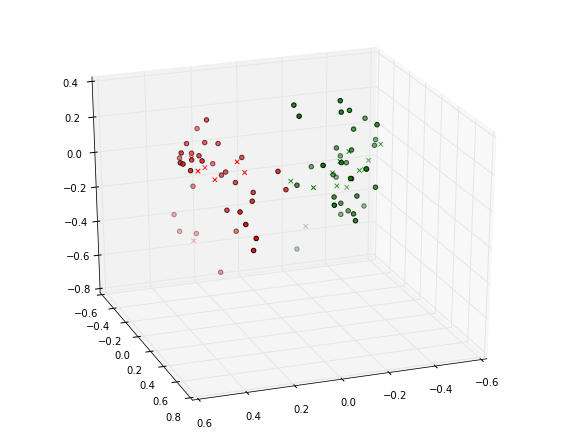

In [20]:
labels_train = [TOPIC1 if _ else TOPIC0 for _ in y_train]
labels_test = [TOPIC1 if _ else TOPIC0 for _ in y_test]
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=70)
for c, i, label in zip('rgb', [0, 1], labels_train):
    ax.scatter(pca_X_train[y_train == i, 0],
               pca_X_train[y_train == i, 1],
               pca_X_train[y_train == i, 2],
               c=c, label=label)
for c, i, label in zip('rgb', [0, 1], [l + ' (test)' for l in labels_test]):
    ax.scatter(pca_X_test[y_test == i, 0],
               pca_X_test[y_test == i, 1],
               pca_X_test[y_test == i, 2],
               c=c, label=label, marker='x')
plt.show()

We see a clear separation between the two classes (red and green) in the training as well as in the test set (dots and crosses).

## Conclusion

When restricting to two topics we were able to predict the correct topic for each question in the test set. This approach can now be generalized to all topics on the Math Education Resources, and machine learning can therefore be used to predict the topic of any question on the website.

This serves two purposes:

1. Help contributors label questions by suggesting sensible topics or label automatically.
2. Help learners find similar questions on related topics, even if the topic label is missing.

In the future we plan to incorporate other data to build a full question-recommendation algorithm that takes the course and difficulty into account.